# Car Evaluation Dataset

The [Car Evaluation dataset](https://archive.ics.uci.edu/dataset/19/car+evaluation) is a collection of data used to assess the acceptability of cars based on factors like buying price, maintenance cost, doors, seating capacity, trunk size, and safety features. It is sourced from the UCI Machine Learning Repository and serves as a popular dataset for exploring classification techniques and decision tree modeling.

The dataset includes 1728 (cars) samples, classified into 4 evaluation level: unacceptable (`unacc`), acceptable (`acc`), good (`good`), and very good (`vgood`).

## Importing Packages

In [ ]:
from ucimlrepo import fetch_ucirepo

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import graphviz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

## Preparing the Datasets

### Importing the Datasets
Fetch the 'Car Evaluation' dataset from UCI.

In [2]:
car_evaluation = fetch_ucirepo(id=19)

### Setting Up the Training and Test Datasets
We will split the original dataset into 4 different splitting strategies, with the proportion of traning and test as follows: 40/60, 60/40, 80/20, and 90/10.

First, we split the original dataset into feature and label columns, as the target we are considering now is `class`, which is car evaluation level in this dataset context.

In [3]:
car_evaluation_target = car_evaluation.data.targets
car_evaluation_features = car_evaluation.data.features

Then the feature and label are split into 4 splitting strategies as mentioned above.

In [4]:
training_sizes = {
    "40/60": 0.4,
    "60/40": 0.6,
    "80/20": 0.8,
    "90/10": 0.9,
}

datasets = {}

for name, training_size in training_sizes.items():
    feature_train, feature_test, label_train, label_test = train_test_split(
        car_evaluation_features, car_evaluation_target,
        test_size=(1 - training_size),
        random_state=42,
        shuffle=True,
        stratify=car_evaluation_target
    )

    datasets[name] = (feature_train, feature_test, label_train, label_test)

After splitting the datasets, the visualization of the class distribution is as follows.

### Original Set

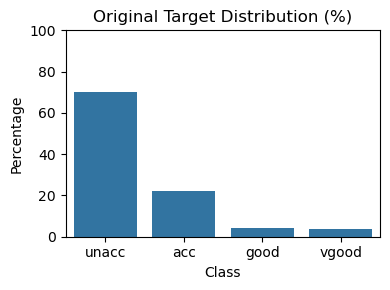

In [5]:
plt.figure(figsize=(4,3))
original_pct = car_evaluation_target.value_counts(normalize=True) * 100

original_df = original_pct.reset_index()
original_df.columns = ["Class", "Percentage"]

sns.barplot(data=original_df, x="Class", y="Percentage")
plt.title("Original Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

### Training Set

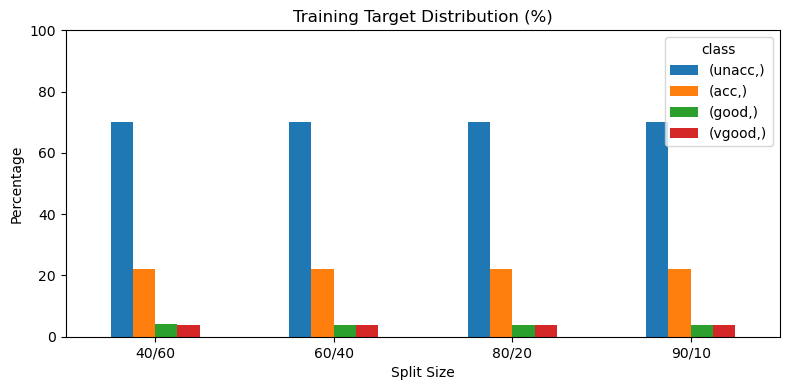

In [6]:
train_distributions = {}

for name, (feature_train, feature_test, label_train, label_test) in datasets.items():
    train_pct = label_train.value_counts(normalize=True) * 100
    train_distributions[name] = train_pct

train_df = pd.DataFrame(train_distributions).T

train_df.plot(kind='bar', figsize=(8, 4), legend=True)
plt.title("Training Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("Split Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Test Set

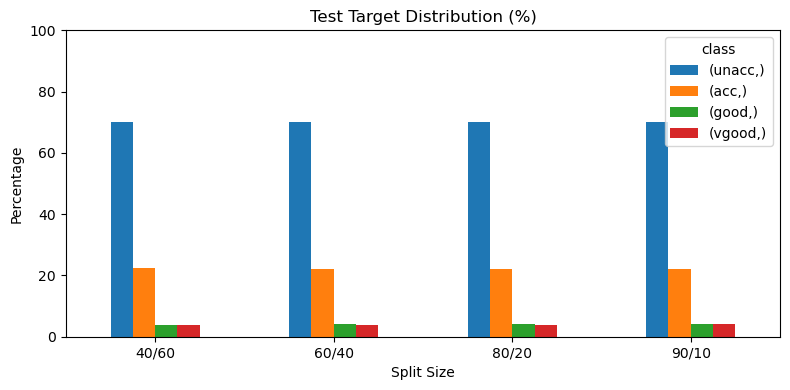

In [7]:
test_distributions = {}

for name, (feature_train, feature_test, label_train, label_test) in datasets.items():
    test_pct = label_test.value_counts(normalize=True) * 100
    test_distributions[name] = test_pct

test_df = pd.DataFrame(test_distributions).T

test_df.plot(kind='bar', figsize=(8, 4), legend=True)
plt.title("Test Target Distribution (%)")
plt.ylim(0, 100)
plt.ylabel("Percentage")
plt.xlabel("Split Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

As can be seen from three plots above, the dataset is relatively balanced across both training and test splits, which indicates that the preparation was appropriate.

However, some features of the datasets appears to be categorical. Therefore, we are going to perform one-hot encoding on categorical feature columns using `sklearn`'s `OneHotEncoder`, together with label encoding on label column using `sklearn`'s `LabelEncoder`.

In [8]:
column_transformer = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(drop='first', sparse_output=False),
         ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])
    ],
    remainder='passthrough'
)

label_encoders = {}
label_encoders_list = {}
feature_names = {}

label_order = ['unacc', 'acc', 'good', 'vgood']

for name, (feature_train, feature_test, label_train, label_test) in datasets.items():
    num_cols = feature_train.columns.difference(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

    feature_train = column_transformer.fit_transform(feature_train)
    feature_test = column_transformer.transform(feature_test)

    one_hot = column_transformer.named_transformers_['categorical']
    one_hot_feature_names = column_transformer.get_feature_names_out(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

    label_train = label_train.values.ravel()
    label_test = label_test.values.ravel()

    label_mapping = {label: i for i, label in enumerate(label_order)}

    label_train = np.array([label_mapping[label] for label in label_train])
    label_test = np.array([label_mapping[label] for label in label_test])

    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(label_order)

    datasets[name] = (feature_train, feature_test, label_train, label_test)
    label_encoders[name] = label_encoder
    label_encoders_list[name] = np.array(label_order)
    feature_names[name] = list(one_hot_feature_names) + list(num_cols)

## Building the Decision Tree Classifiers

After preparing the datasets, we now fit a Decision Tree Classifier to each training set and visualize the decision tree result.

### Model Training
We apply the `DecisionTreeClassifier` on each splitted subsets. To use information gain, we set `criterion` parameter to be `'entropy'`, and `random_state` is set to `42` for mainaining consistency between the notebook and the report.

In [9]:
models = {}

for name, (feature_train, feature_test, label_train, label_test) in datasets.items():
    model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
    model.fit(feature_train, label_train)

    models[name] = model

### Visualization
The visualization of the resulting decision trees is processed with Graphviz. We set `feature_names` and `class_names` to be the preprocessed lists of feature and label names for easy reading when visualizing the trees.

In [10]:
graphs = {}

for name, model in models.items():
    dot_data = tree.export_graphviz(model, out_file=None,
                                    feature_names=feature_names[name],
                                    class_names=label_encoders[name].classes_,
                                    filled=True, rounded=True)
    graph = graphviz.Source(dot_data)

    graphs[name] = graph

Decision Tree Graph for 40/60 splitting.

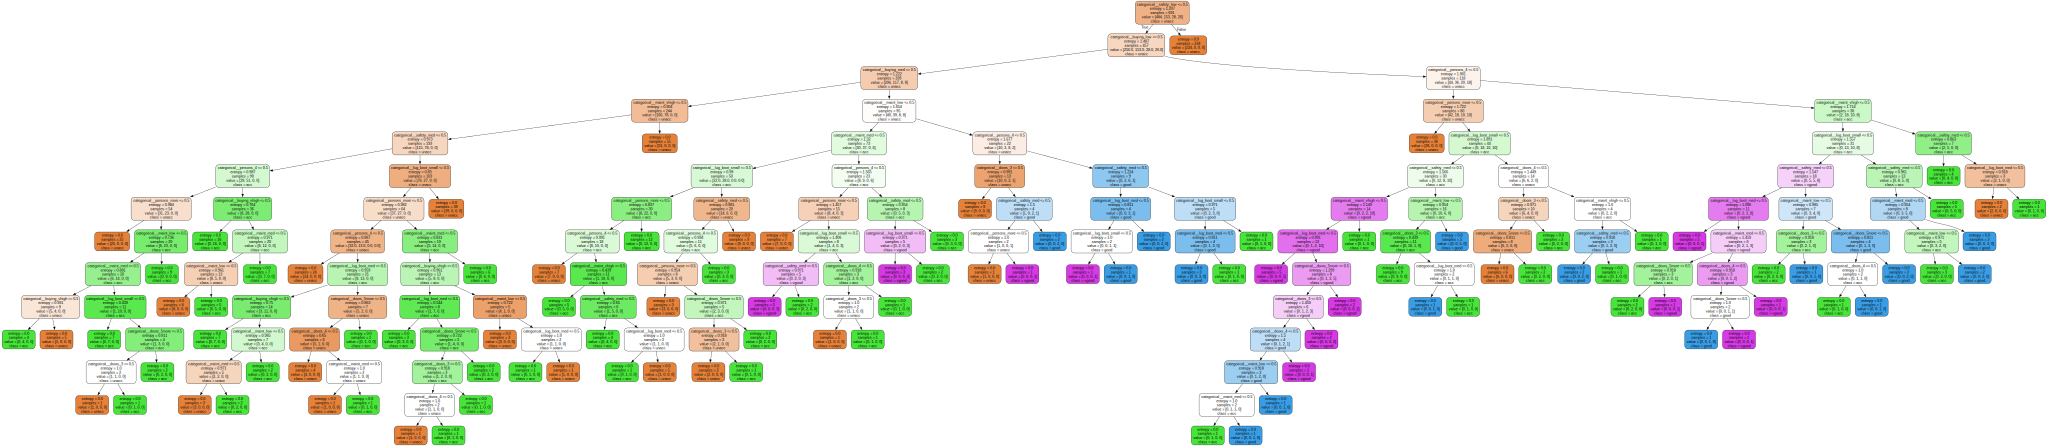

In [11]:
graphs['40/60']

Decision Tree Graph for 60/40 splitting.

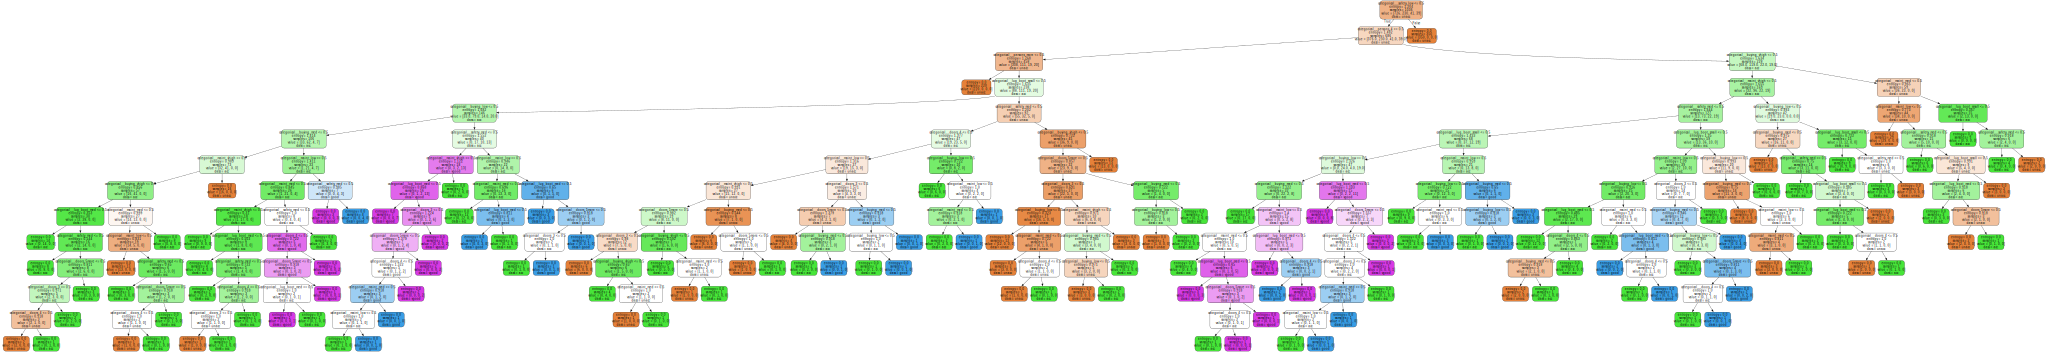

In [12]:
graphs['60/40']

Decision Tree Graph for 80/20 splitting.

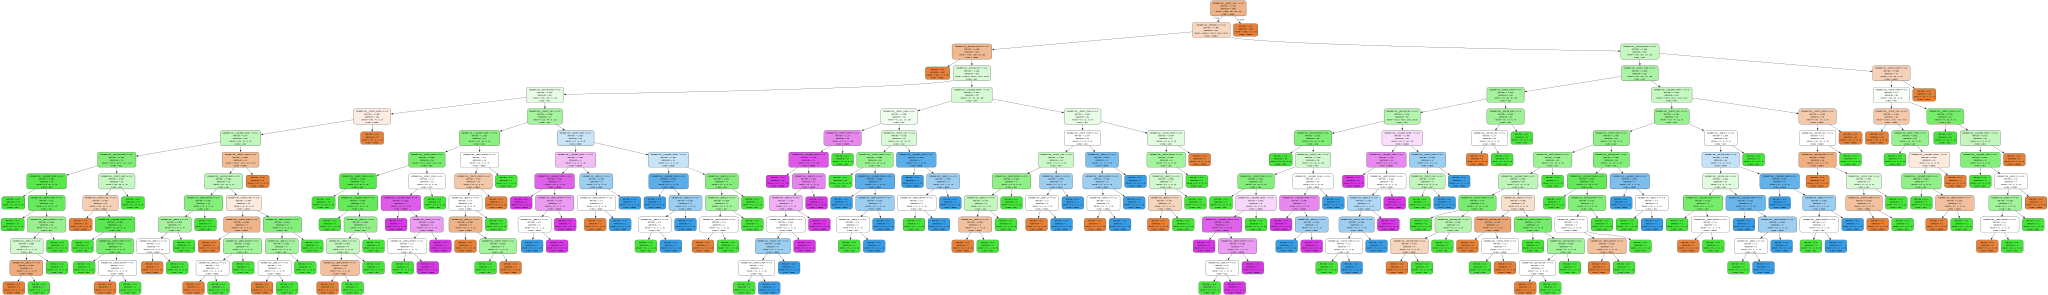

In [13]:
graphs['80/20']

Decision Tree Graph for 90/10 splitting.

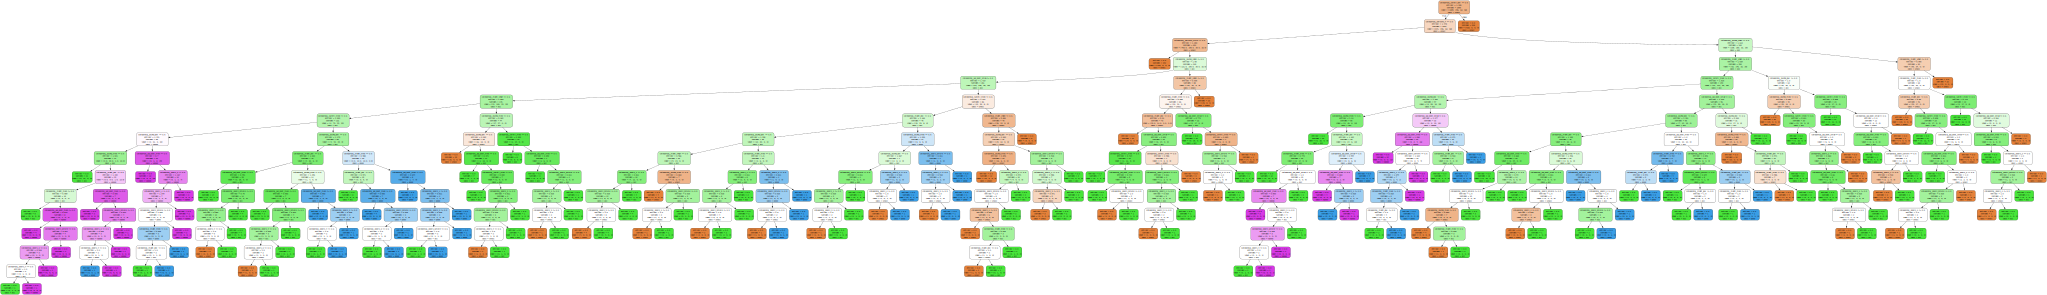

In [14]:
graphs['90/10']

## Evaluating the Decison Tree Classifiers

For each of the trained classifiers, we will predict the samples using test set and use them, with `classification_report` and `confusion_matrix`, to generate the classification report and the confusion matrix.

First, we define the function for displaying necessary information. The function uses the generated `confusion_matrix` and `ConfusionMatrixDisplay` from `sklearn`, and `matplotlib` to display the confusion matrix.

In [15]:
def evaluating_tree_classifiers(model, name):
    (_, feature_test, _, label_test) = datasets[name]

    X_test = feature_test
    y_test = label_test.squeeze()
    y_pred = model.predict(X_test)
    
    report_dict = classification_report(
        y_test, y_pred, target_names=label_encoders_list[name], output_dict=True
    )
    report_df = pd.DataFrame(report_dict).transpose()

    display(report_df.round(2))

    class_count = len(label_encoders_list[name])
    cm = confusion_matrix(y_test, y_pred, labels=range(class_count))
    depth = model.get_depth()
    
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoders_list[name])
    disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical', ax=plt.gca())
    plt.title(f"Confusion Matrix (Depth={depth}, {name} Split)")
    plt.tight_layout()
    plt.xticks(rotation=0)
    plt.yticks(rotation=90)
    plt.grid(False)
    plt.show()

Then, after applying the function to every splitting strategies, the evaluation of those trees are illustrated as follows:

### a. 40/60 Splitting

,precision,recall,f1-score,support
unacc,0.95,0.97,0.96,726.00
acc,0.84,0.86,0.85,231.00
good,0.46,0.27,0.34,41.00
vgood,0.88,0.77,0.82,39.00
accuracy,0.91,0.91,0.91,0.91
macro avg,0.78,0.72,0.74,1037.00
weighted avg,0.91,0.91,0.91,1037.00


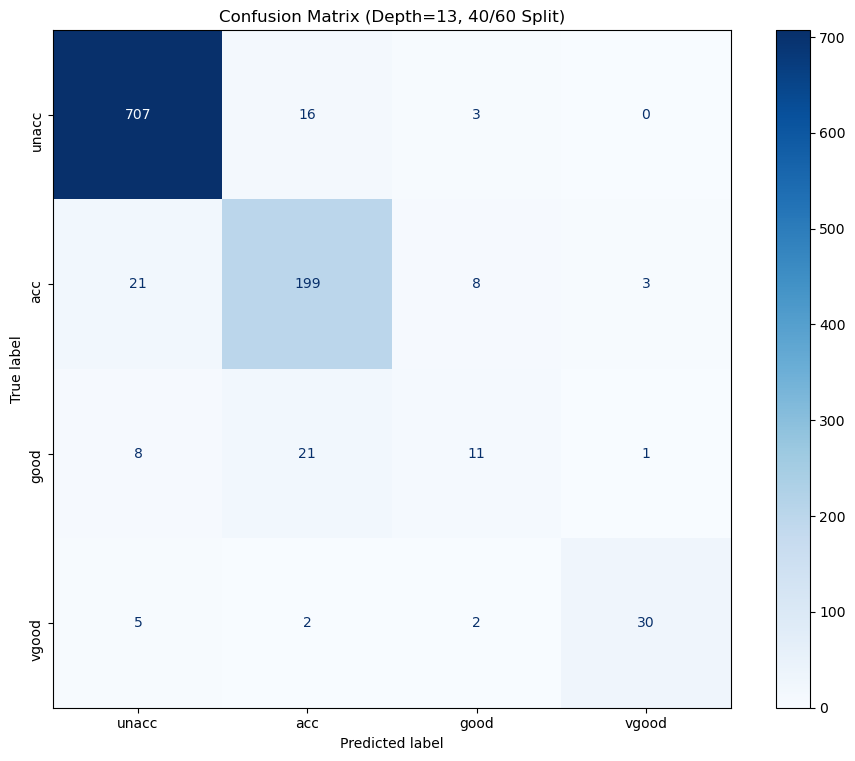

In [16]:
evaluating_tree_classifiers(models['40/60'], '40/60')

#### Evaluation and insights:
**Classification Report:**

- `unacc`: The model performs exceptionally well, with a **precision of 0.95** and **recall of 0.97**, resulting in a high **f1-score of 0.96**. With a support of 726 samples (accounts for ~70% of total samples), this class is well represented and clearly learned by the model.

- `acc`: This class also performs decently, with **precision = 0.84** and **recall = 0.86**, yielding an **f1-score = 0.85**. With 231 samples, the model seems reasonably confident and consistent.

- `good`: The performance drops significantly here. **Precision = 0.46**, **recall = 0.27**, and **f1-score = 0.34**, which suggests the model struggles to detect this class effectively. This may be due to its **small support (41 samples)**, leading to **underrepresentation**.

- `vgood`: Precision is relatively high at **0.88**, but recall is only **0.77**, resulting in an **f1-score of 0.82**. Again, with only 39 samples, the model likely finds it hard to distinguish this class confidently.

- **Accuracy**: The overall accuracy is **0.91**, indicating that the model correctly predicts the class in the majority of cases.

- **Macro Average**: With **macro precision = 0.78**, **macro recall = 0.72**, and **macro f1-score = 0.74**, we see that the model performs **quite unevenly across classes** — treating each class equally regardless of size.

- **Weighted Average**: The **weighted precision, recall, and f1-score** are all **0.91**, closely matching accuracy. This shows that the model performs well **on average**, but mainly due to good performance on **majority classes** like `unacc` and `acc`.

- Overall, the difference betwwen macro and weighted averages suggest the model is **biased toward majority classes**, and has **difficulty detecting underrepresented classes**, such as `good` and `vgood`.

**Confusion Matrix:**

- Most predictions for `unacc`, `acc` and `vgood` are correct, showing that the model is highly confident in classifying these class.

- **Misclassifications** are most noticeable in the `good` class, which is often confused with `acc`, likely due to limited training examples.

- There are very few false positives for `unacc`, indicating strong precision.

- Overall, the confusion matrix confirms that the models handles **major classes** quite well, but it still needs improvements in classification among **minor classes**.

#### b. 60/40 Splitting

,precision,recall,f1-score,support
unacc,0.97,0.96,0.97,484.00
acc,0.81,0.89,0.85,154.00
good,0.81,0.46,0.59,28.00
vgood,0.96,0.92,0.94,26.00
accuracy,0.92,0.92,0.92,0.92
macro avg,0.89,0.81,0.84,692.00
weighted avg,0.93,0.92,0.92,692.00


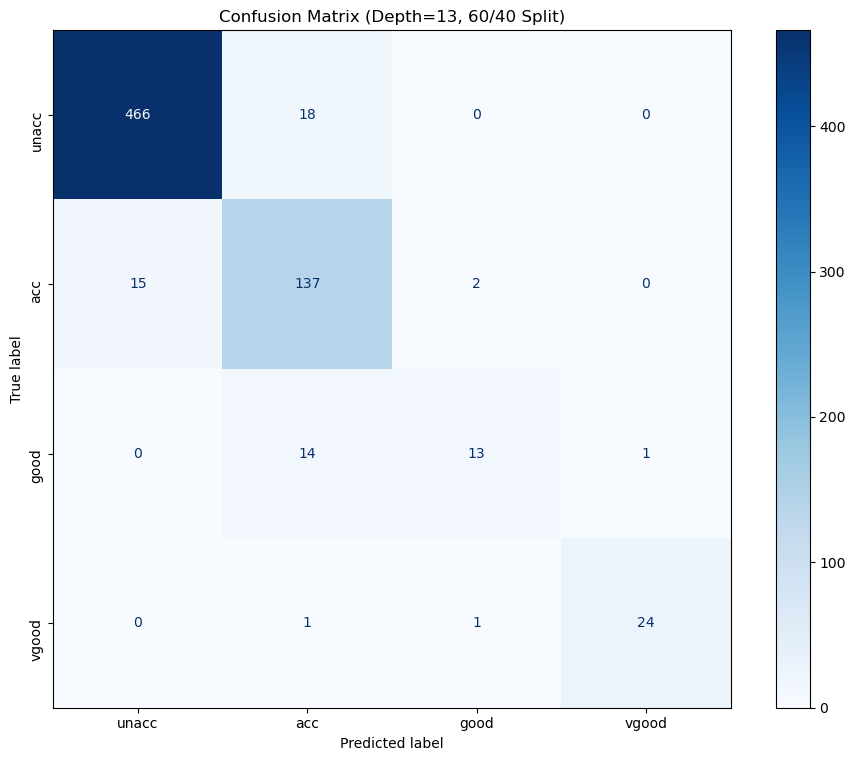

In [17]:
evaluating_tree_classifiers(models['60/40'], '60/40')

#### c. 80/20 Splitting

,precision,recall,f1-score,support
unacc,0.96,0.97,0.96,242.00
acc,0.82,0.90,0.86,77.00
good,0.75,0.43,0.55,14.00
vgood,1.00,0.77,0.87,13.00
accuracy,0.92,0.92,0.92,0.92
macro avg,0.88,0.77,0.81,346.00
weighted avg,0.92,0.92,0.92,346.00


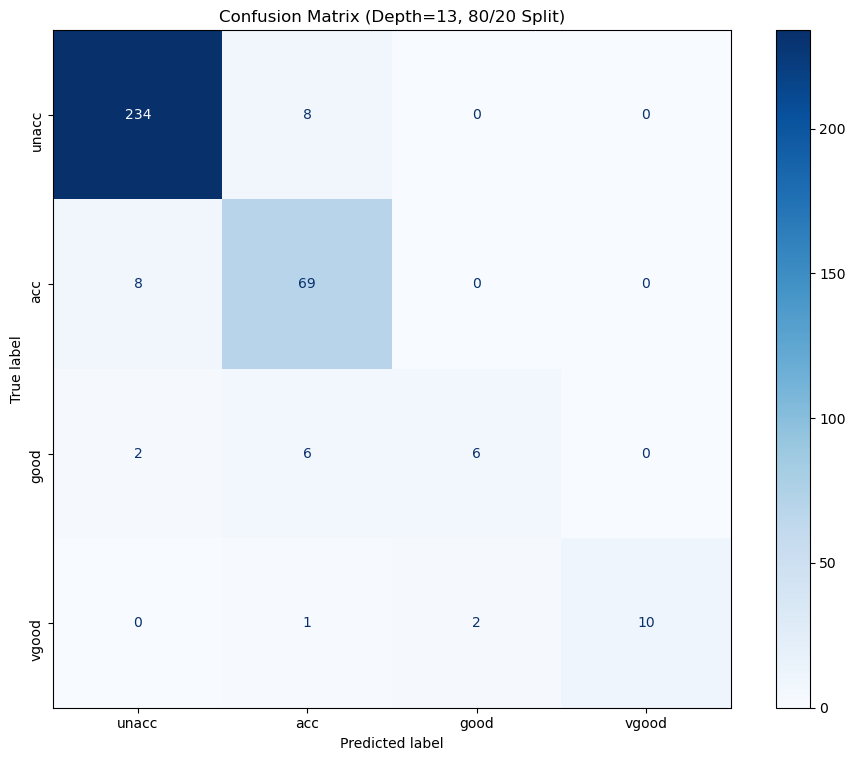

In [18]:
evaluating_tree_classifiers(models['80/20'], '80/20')

#### d. 90/10 Splitting

,precision,recall,f1-score,support
unacc,0.94,0.98,0.96,121.00
acc,0.84,0.84,0.84,38.00
good,0.75,0.43,0.55,7.00
vgood,1.00,0.86,0.92,7.00
accuracy,0.92,0.92,0.92,0.92
macro avg,0.88,0.78,0.82,173.00
weighted avg,0.92,0.92,0.92,173.00


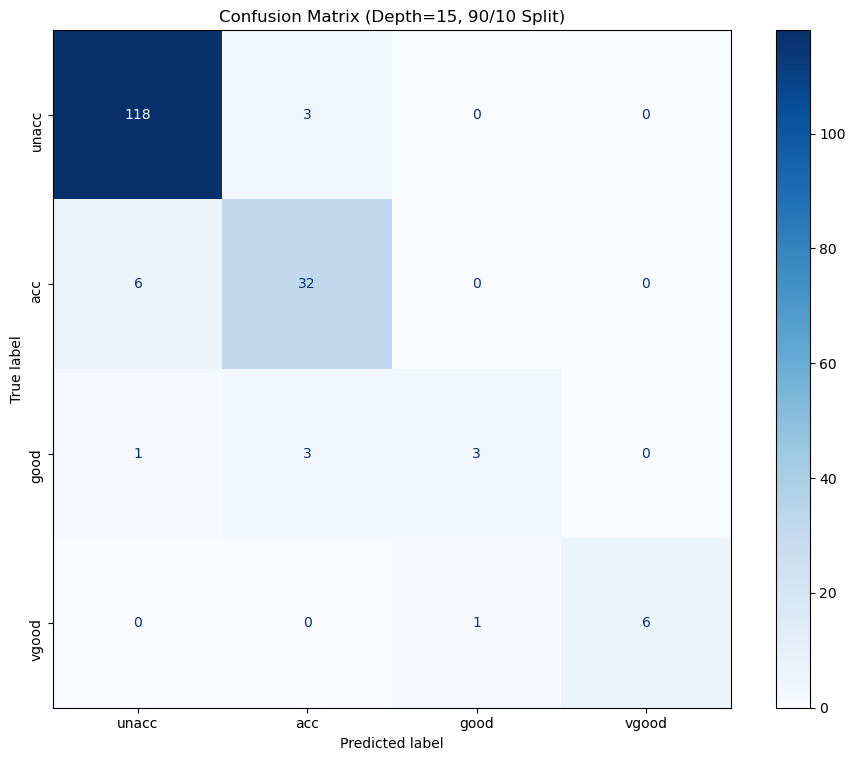

In [19]:
evaluating_tree_classifiers(models['90/10'], '90/10')

#### e. Overall Insights

## The Depth and Accuracy of A Decision Tree (80/20 Splitting)

In this section, the task focuses on the 80/20 splitting. We are specifying the maximum depth of a decision tree by testing with the following values: `[None, 2, 3, 4, 5, 6, 7]`. For each depth value, the processing procedure will be: providing the decision tree, visualizing using Graphviz, reporting and visualizing the `accuracy_score`.

As the 80/20 dataset was preprocessed above, we will skip this section.

### Preparing
However, we still have to prepare the testing values.

In [20]:
max_depth_values = [None, 2, 3, 4, 5, 6, 7]

(feature_train, feature_test, label_train, label_test) = datasets['80/20']

### Model Training
After preprocessing the data, we apply the `DecisionTreeClassifier` on the dataset with each depth value.

In [21]:
models = {}

for max_depth in max_depth_values:
    depth_label = f"Depth={max_depth if max_depth is not None else 'None'}"

    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    model.fit(feature_train, label_train)

    models[depth_label] = model

### Visualization
The visualization of the resulting decision trees is processed with Graphviz.

In [22]:
graphs = {}

for max_depth, model in models.items():
    dot_data = tree.export_graphviz(model, out_file=None,
                                    feature_names=feature_names['80/20'],
                                    class_names=label_encoders['80/20'].classes_,
                                    filled=True, rounded=True)
    graph = graphviz.Source(dot_data)

    graphs[max_depth] = graph

Depth = `None`

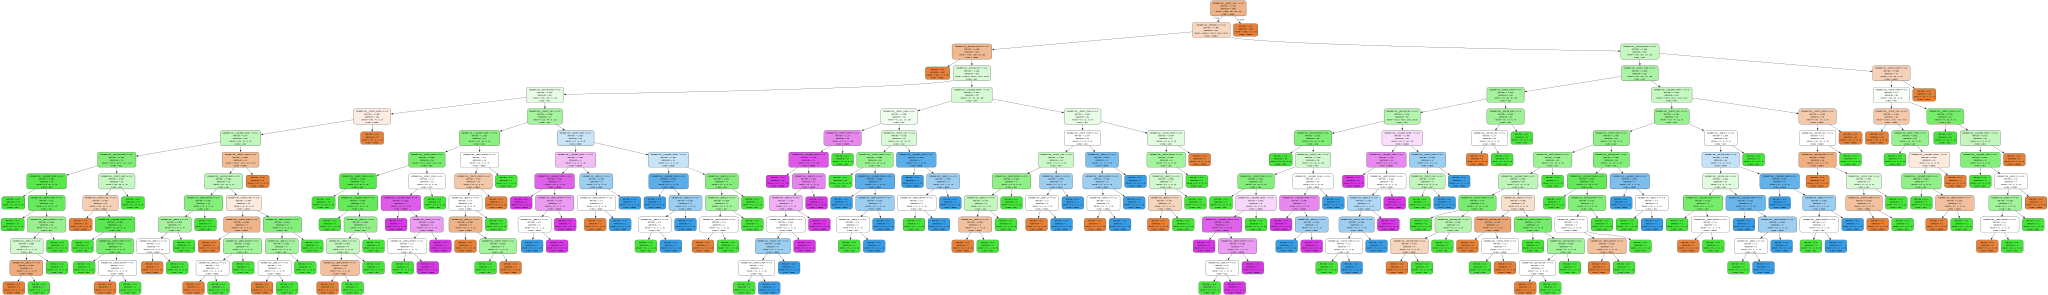

In [23]:
graphs['Depth=None']

Depth = `None`

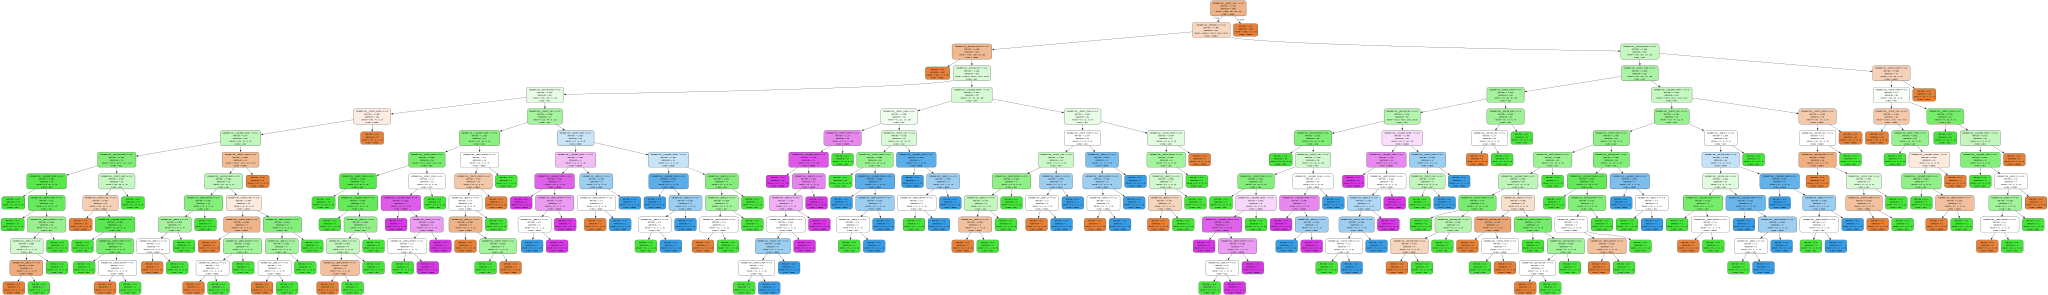

In [24]:
graphs['Depth=None']

Depth = `2`

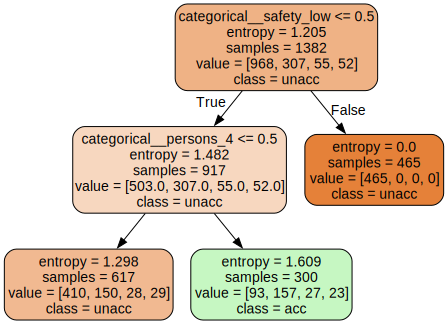

In [25]:
graphs['Depth=2']

Depth = `3`

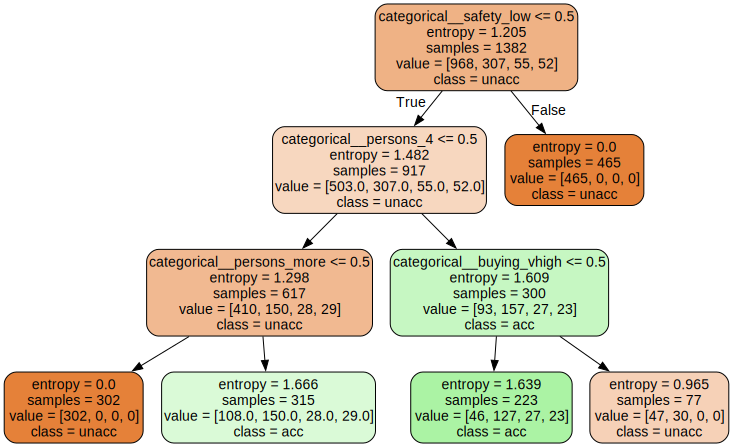

In [26]:
graphs['Depth=3']

Depth = `4`

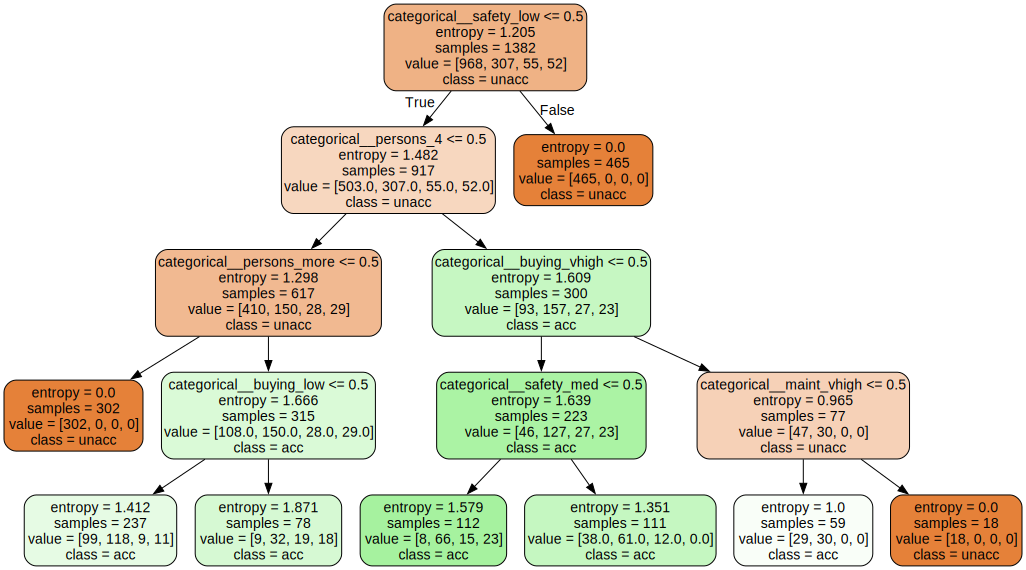

In [27]:
graphs['Depth=4']

Depth = `5`

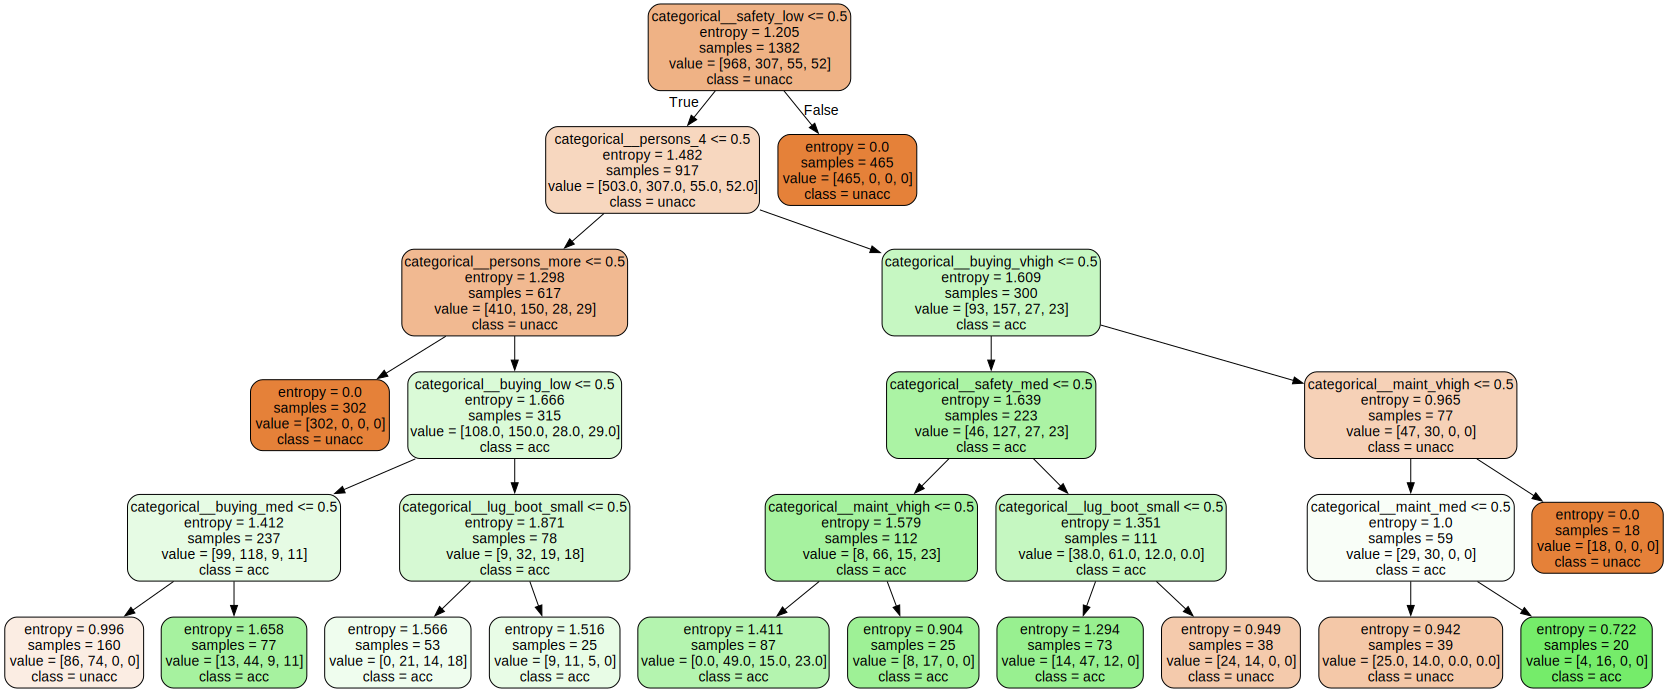

In [28]:
graphs['Depth=5']

Depth = `6`

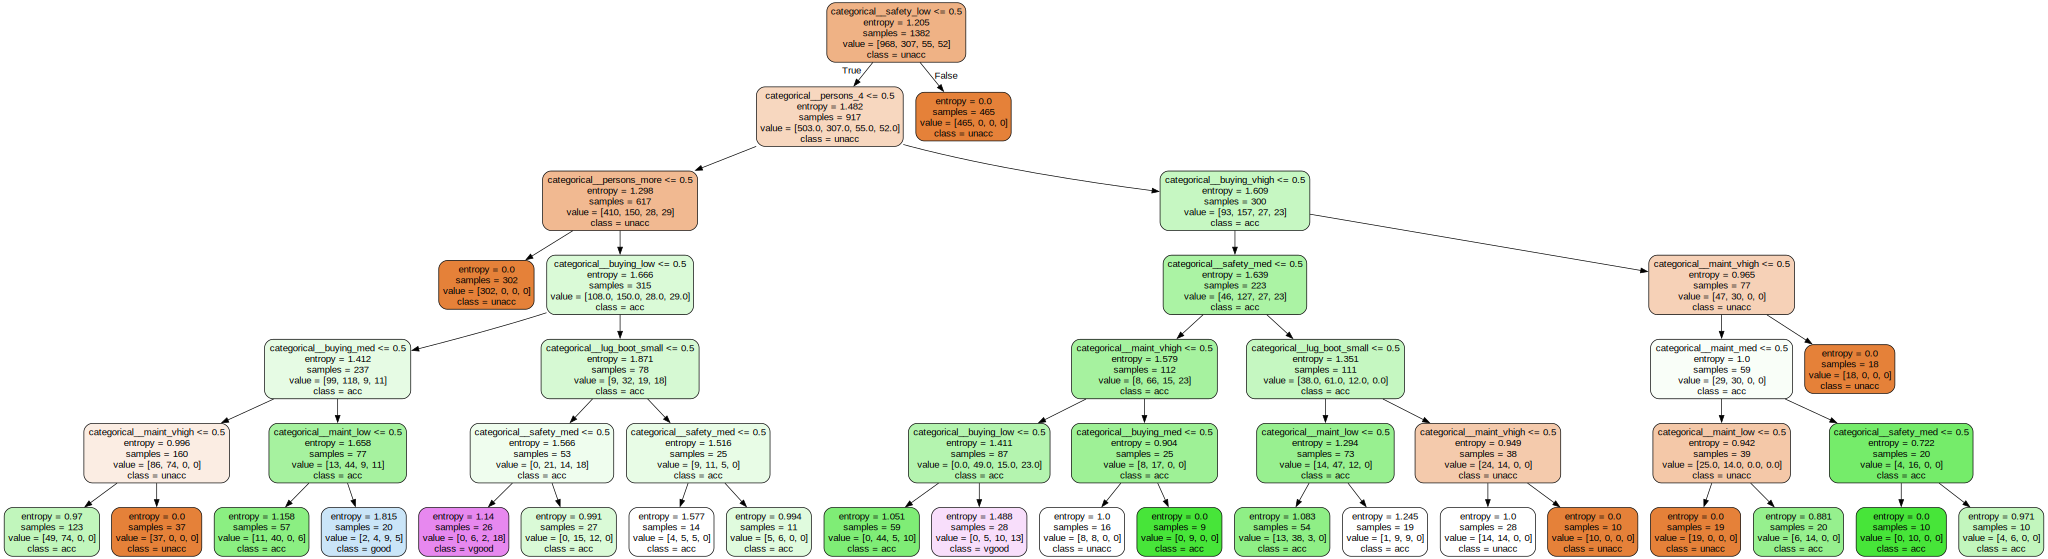

In [29]:
graphs['Depth=6']

Depth = `7`

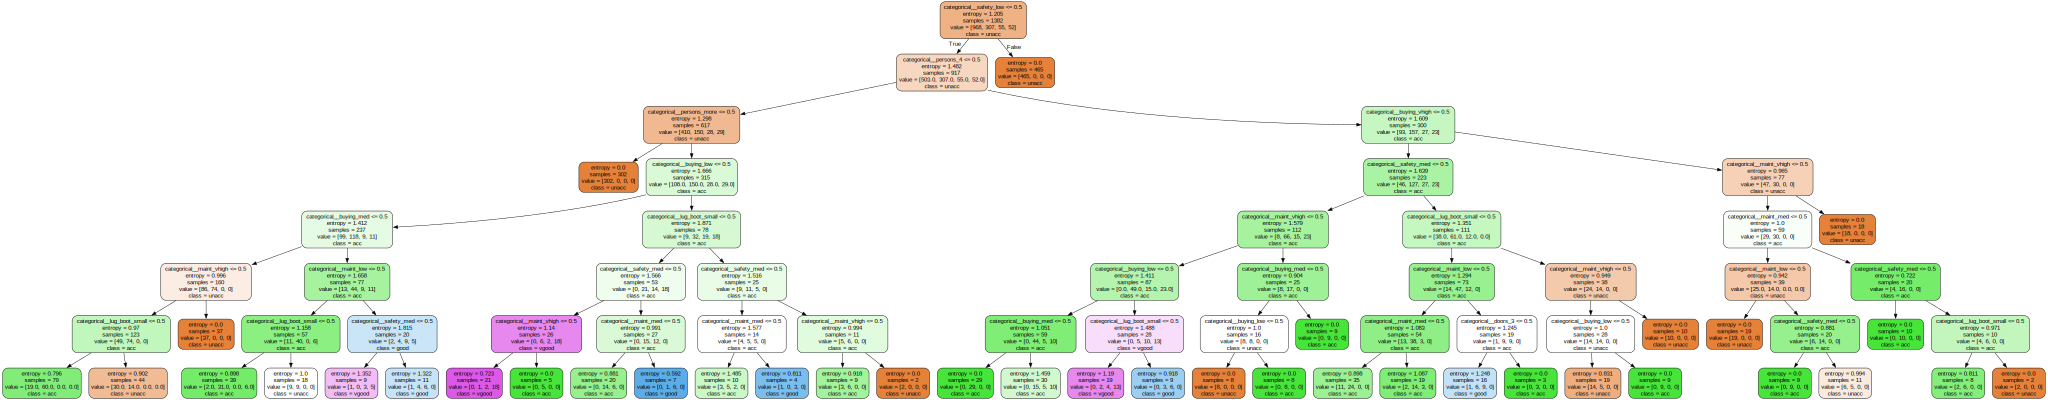

In [30]:
graphs['Depth=7']

### Accuracy Scores

Finally, we will calculate the accuracy scores for each depth value on the test set of the decision tree classifier.

In [31]:
accuracy_scores = {}

for max_depth, model in models.items():
    label_pred = model.predict(feature_test)
    accuracy = accuracy_score(label_test, label_pred)
    accuracy_scores[max_depth] = accuracy

flat_scores = {
    k.replace("Depth=", "").replace("None", "None"): v 
    for k, v in accuracy_scores.items()
}

flat_scores = dict(sorted(
    flat_scores.items(),
    key=lambda x: 1 if x[0] == "None" else int(x[0])
))

accuracy_table = pd.DataFrame([flat_scores], index=["Accuracy"]).round(4)

accuracy_table

,None,2,3,4,5,6,7
Accuracy,0.922,0.7399,0.8006,0.7977,0.7948,0.8555,0.9104


### Overall Insights